# **Importing the packages and data**

In this stage we are performing the below tasks

1.Import packages.

2.Imported data using google drive.

In [1]:
# Install the required libraries.
!pip install pafy youtube-dl moviepy

     |████████████████████████████████| 1.9 MB 6.5 MB/s 


In [2]:
# Import the required libraries.
import os
import cv2
import pafy
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt
 
from moviepy.editor import *
%matplotlib inline
 
from sklearn.model_selection import train_test_split
 
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)1916928/45929032 bytes (4.2%)5292032/45929032 bytes (11.5%)8314880/45929032 bytes (18.1%)11649024/45929032 bytes (25.4%)15466496/45929032 bytes (33.7%)18546688/45929032 bytes (40.4%)21708800/45929032 bytes (47.3%)25231360/45929032 bytes (54.9%)28131328/45929032 bytes (61.2%)31621120/45929032 bytes (68.8%)34635776/45929032 bytes (75.4%)38043648/45929032 bytes (82.8%)

In [3]:
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

# **Step 1: Download and Visualize the Data with its Labels**

In [4]:
# Discard the output of this cell.
%%capture
 
# Downlaod the UCF50 Dataset
!wget --no-check-certificate https://www.crcv.ucf.edu/data/UCF50.rar
 
#Extract the Dataset
!unrar x UCF50.rar

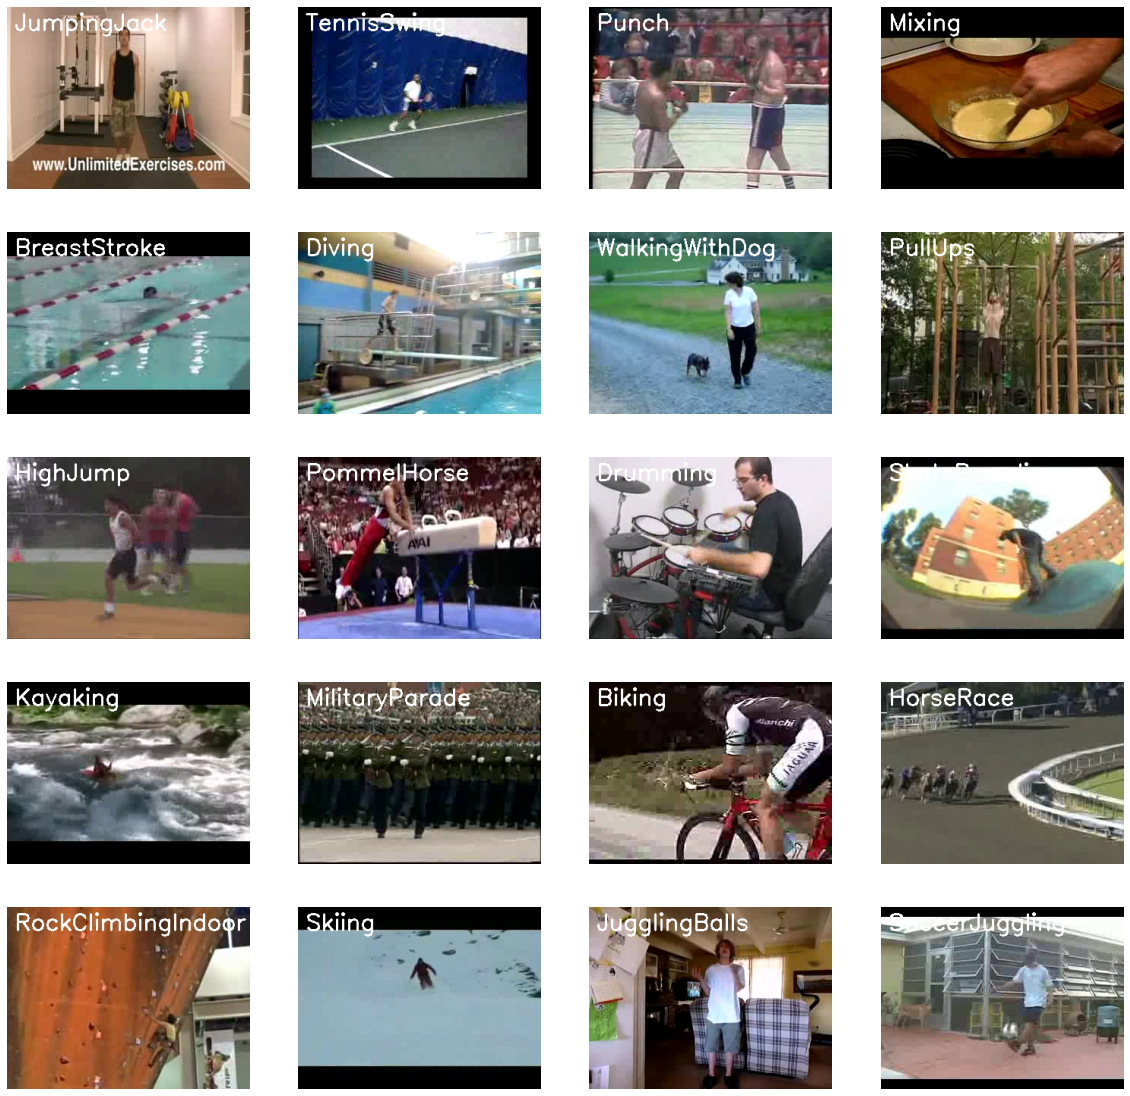

In [5]:
# Create a Matplotlib figure and specify the size of the figure.
plt.figure(figsize = (20, 20))
 
# Get the names of all classes/categories in UCF50.
all_classes_names = os.listdir('UCF50')
 
# Generate a list of 20 random values. The values will be between 0-50, 
# where 50 is the total number of class in the dataset. 
random_range = random.sample(range(len(all_classes_names)), 20)
 
# Iterating through all the generated random values.
for counter, random_index in enumerate(random_range, 1):
 
    # Retrieve a Class Name using the Random Index.
    selected_class_Name = all_classes_names[random_index]
 
    # Retrieve the list of all the video files present in the randomly selected Class Directory.
    video_files_names_list = os.listdir(f'UCF50/{selected_class_Name}')
 
    # Randomly select a video file from the list retrieved from the randomly selected Class Directory.
    selected_video_file_name = random.choice(video_files_names_list)
 
    # Initialize a VideoCapture object to read from the video File.
    video_reader = cv2.VideoCapture(f'UCF50/{selected_class_Name}/{selected_video_file_name}')
    
    # Read the first frame of the video file.
    _, bgr_frame = video_reader.read()
 
    # Release the VideoCapture object. 
    video_reader.release()
 
    # Convert the frame from BGR into RGB format. 
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)
 
    # Write the class name on the video frame.
    cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    
    # Display the frame.
    plt.subplot(5, 4, counter);plt.imshow(rgb_frame);plt.axis('off')

# **Step 2: Preprocess the Dataset**

In [6]:
# Specify the height and width to which each video frame will be resized in our dataset.
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64
 
# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 20
 
# Specify the directory containing the UCF50 dataset. 
DATASET_DIR = "UCF50"
 
# Specify the list containing the names of the classes used for training. Feel free to choose any set of classes.
CLASSES_LIST = ["WalkingWithDog", "TaiChi", "Swing", "HorseRace", "BaseballPitch","BenchPress","CleanAndJerk", "Diving","Drumming", "Fencing", "GolfSwing", "PlayingGuitar"]

# Create a Function to Extract, Resize & Normalize Frames

In [7]:
def frames_extraction(video_path):
    '''
    This function will extract the required frames from a video after resizing and normalizing them.
    Args:
        video_path: The path of the video in the disk, whose frames are to be extracted.
    Returns:
        frames_list: A list containing the resized and normalized frames of the video.
    '''
 
    # Declare a list to store video frames.
    frames_list = []
    
    # Read the Video File using the VideoCapture object.
    video_reader = cv2.VideoCapture(video_path)
 
    # Get the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
 
    # Calculate the the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)
 
    # Iterate through the Video Frames.
    for frame_counter in range(SEQUENCE_LENGTH):
 
        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
 
        # Reading the frame from the video. 
        success, frame = video_reader.read() 
 
        # Check if Video frame is not successfully read then break the loop
        if not success:
            break
 
        # Resize the Frame to fixed height and width.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255
        
        # Append the normalized frame into the frames list
        frames_list.append(normalized_frame)
    
    # Release the VideoCapture object. 
    video_reader.release()
 
    # Return the frames list.
    return frames_list

# Create a Function for Dataset Creation

In [8]:
def create_dataset():
    '''
    This function will extract the data of the selected classes and create the required dataset.
    Returns:
        features:          A list containing the extracted frames of the videos.
        labels:            A list containing the indexes of the classes associated with the videos.
        video_files_paths: A list containing the paths of the videos in the disk.
    '''
 
    # Declared Empty Lists to store the features, labels and video file path values.
    features = []
    labels = []
    video_files_paths = []
    
    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(CLASSES_LIST):
        
        # Display the name of the class whose data is being extracted.
        print(f'Extracting Data of Class: {class_name}')
        
        # Get the list of video files present in the specific class name directory.
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
        
        # Iterate through all the files present in the files list.
        for file_name in files_list:
            
            # Get the complete video path.
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)
 
            # Extract the frames of the video file.
            frames = frames_extraction(video_file_path)
 
            # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified above.
            # So ignore the vides having frames less than the SEQUENCE_LENGTH.
            if len(frames) == SEQUENCE_LENGTH:
 
                # Append the data to their repective lists.
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)
 
    # Converting the list to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels)  
    
    # Return the frames, class index, and video file path.
    return features, labels, video_files_paths

In [9]:
# Create the dataset.
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: WalkingWithDog
Extracting Data of Class: TaiChi
Extracting Data of Class: Swing
Extracting Data of Class: HorseRace
Extracting Data of Class: BaseballPitch
Extracting Data of Class: BenchPress
Extracting Data of Class: CleanAndJerk
Extracting Data of Class: Diving
Extracting Data of Class: Drumming
Extracting Data of Class: Fencing
Extracting Data of Class: GolfSwing
Extracting Data of Class: PlayingGuitar


In [10]:
label_map = {
    0: 'WalkingWithDog',
    1: 'TaiChi',  
    2: 'Swing', 
    3: 'HorseRace',  
    4: 'BaseballPitch',  
    5: 'BenchPress',  
    6: 'CleanAndJerk',
    7: 'Diving', 
    8: 'Drumming', 
    9: 'Fencing', 
    10: 'GolfSwing', 
    11: 'PlayingGuitar' 
}

In [11]:
# Using Keras's to_categorical method to convert labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(labels)

# **Step 3: Split the Data into Train and Test Set**

In [12]:
# Split the Data into Train ( 75% ) and Test Set ( 25% ).
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size = 0.25, shuffle = True, random_state = seed_constant)

# **Step 4: Implement the ConvLSTM Approach**

# Step 4.1: Construct the Model

In [13]:
def create_convlstm_model():
    '''
    This function will construct the required convlstm model.
    Returns:
        model: It is the required constructed convlstm model.
    '''
 
    # We will use a Sequential model for model construction
    model = Sequential()
 
    # Define the Model Architecture.
    ########################################################################################################################
    
    model.add(ConvLSTM2D(filters = 4, kernel_size = (3, 3), activation = 'tanh',data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True, input_shape = (SEQUENCE_LENGTH,
                                                                                      IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 8, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 14, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 16, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    #model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(Flatten()) 
    
    model.add(Dense(len(CLASSES_LIST), activation = "softmax"))
    
    ########################################################################################################################
     
    # Display the models summary.
    model.summary()
    
    # Return the constructed convlstm model.
    return model

In [14]:
# Construct the required convlstm model.
convlstm_model = create_convlstm_model()
 
# Display the success message. 
print("Model Created Successfully!")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 20, 62, 62, 4)     1024      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 20, 31, 31, 4)    0         
 )                                                               
                                                                 
 time_distributed (TimeDistr  (None, 20, 31, 31, 4)    0         
 ibuted)                                                         
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 20, 29, 29, 8)     3488      
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 20, 15, 15, 8)    0         
 3D)                                                             
                                                        

# Check Model’s Structure:

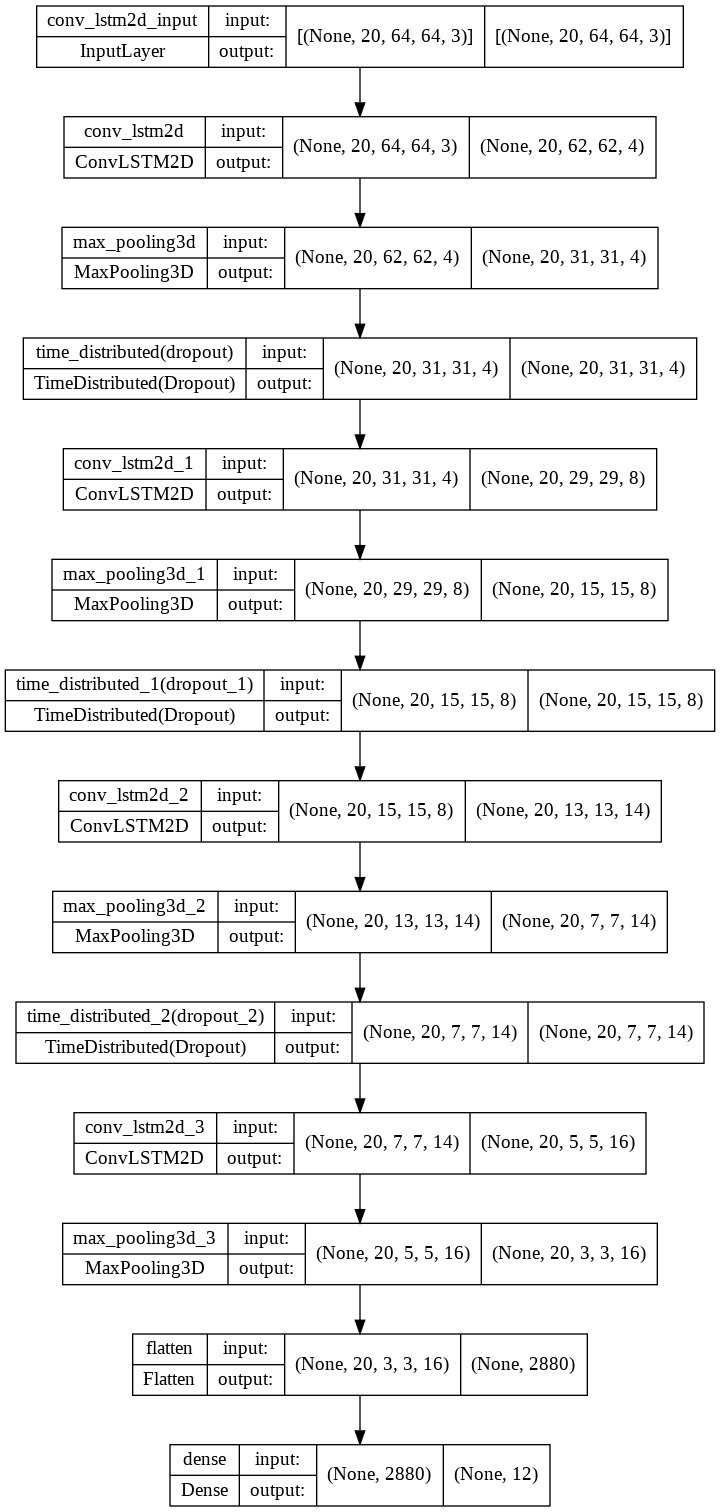

In [15]:

# Plot the structure of the contructed model.
plot_model(convlstm_model, to_file = 'convlstm_model_structure_plot.png', show_shapes = True, show_layer_names = True)

In [16]:
# Create an Instance of Early Stopping Callback
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', restore_best_weights = True)
 
# Compile the model and specify loss function, optimizer and metrics values to the model
convlstm_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])
 
# Start training the model.
convlstm_model_training_history = convlstm_model.fit(x = features_train, y = labels_train, epochs = 15, batch_size = 4,shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])


Epoch 1/15
246/246 [==============================] - 128s 443ms/step - loss: 2.1880 - accuracy: 0.2192 - val_loss: 1.9286 - val_accuracy: 0.2805
Epoch 2/15
246/246 [==============================] - 108s 438ms/step - loss: 1.5340 - accuracy: 0.4873 - val_loss: 1.5369 - val_accuracy: 0.4146
Epoch 3/15
246/246 [==============================] - 108s 439ms/step - loss: 1.1263 - accuracy: 0.6137 - val_loss: 1.3260 - val_accuracy: 0.5569
Epoch 4/15
246/246 [==============================] - 108s 438ms/step - loss: 0.7167 - accuracy: 0.7554 - val_loss: 1.4169 - val_accuracy: 0.5772
Epoch 5/15
246/246 [==============================] - 108s 439ms/step - loss: 0.5626 - accuracy: 0.8114 - val_loss: 1.2074 - val_accuracy: 0.6138
Epoch 6/15
246/246 [==============================] - 108s 437ms/step - loss: 0.3705 - accuracy: 0.8838 - val_loss: 1.6594 - val_accuracy: 0.5976
Epoch 7/15
246/246 [==============================] - 108s 437ms/step - loss: 0.2747 - accuracy: 0.9123 - val_loss: 1.1616 -

# Evaluate the Trained Model

In [17]:
# Evaluate the trained model.
model_evaluation_history = convlstm_model.evaluate(features_test, labels_test)

13/13 [==============================] - 1s 76ms/step - loss: 1.0439 - accuracy: 0.7800


# Save the Model

In [18]:
# Get the loss and accuracy from model_evaluation_history.
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history
 
# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)
 
# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'convlstm_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'
 
# Save your Model.
convlstm_model.save(model_file_name)

# Step 4.3: Plot Model’s Loss & Accuracy Curves

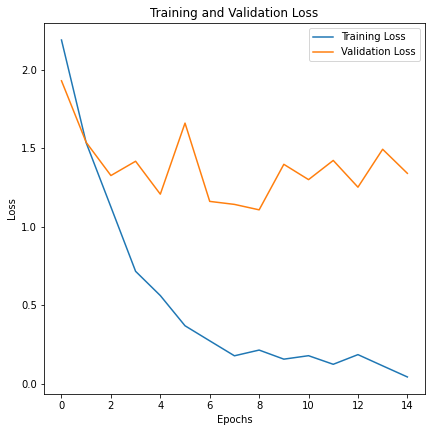

In [20]:
# Visualize the training and validation loss metrices.


loss = convlstm_model_training_history.history['loss']
val_loss = convlstm_model_training_history.history['val_loss']

epoch_value=15
epochs_range = range(epoch_value)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()


Text(0, 0.5, 'Accuracy')

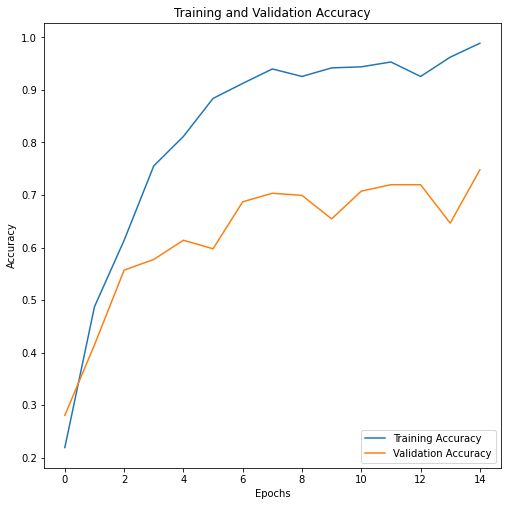

In [21]:
# Visualize the training and validation accuracy metrices.

accuracy = convlstm_model_training_history.history['accuracy']
val_accuracy = convlstm_model_training_history.history['val_accuracy']

epochs_range = range(epoch_value)

plt.figure(figsize=(18, 18))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")


# Step 4.4: Plot Model’s Confusion Matrix

In [22]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = convlstm_model.predict(features_test)
Y_pred_classes = np.argmax(y_pred,axis = 1)
Y_true = np.argmax(labels_test,axis = 1)
cm = confusion_matrix(Y_true, Y_pred_classes)

Text(0.5, 1.0, 'Confusion Matrix')

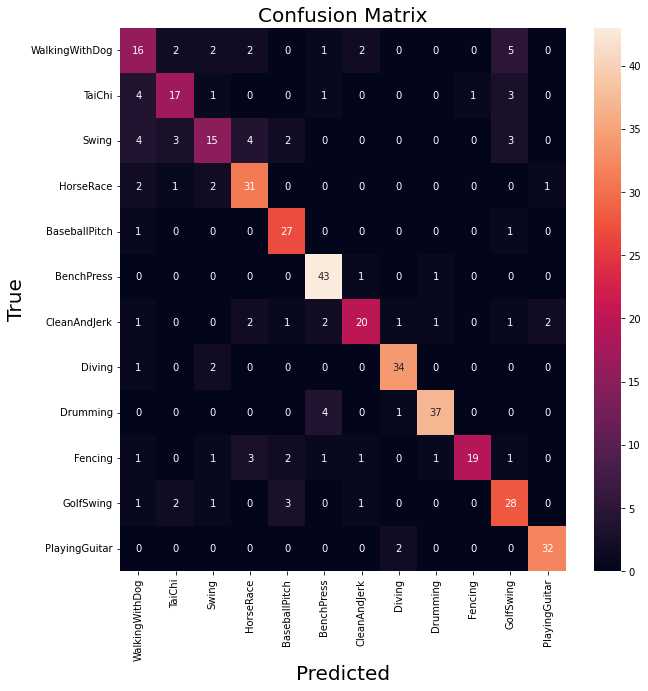

In [23]:
from sklearn.metrics import ConfusionMatrixDisplay
import seaborn as sns


fig = plt.figure(figsize=(10, 10))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g'); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted', fontsize=20)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(CLASSES_LIST, fontsize = 10)
ax.xaxis.tick_bottom()

ax.set_ylabel('True', fontsize=20)
ax.yaxis.set_ticklabels(CLASSES_LIST, fontsize = 10)
plt.yticks(rotation=0)

plt.title('Confusion Matrix', fontsize=20)

# **Step 5: Implement the LRCN Approach**

In this step, we will implement the LRCN Approach by combining Convolution and LSTM layers in a single model. Another similar approach can be to use a CNN model and LSTM model trained separately. The CNN model can be used to extract spatial features from the frames in the video, and for this purpose, a pre-trained model can be used, that can be fine-tuned for the problem. And the LSTM model can then use the features extracted by CNN, to predict the action being performed in the video.


But here, we will implement another approach known as the Long-term Recurrent Convolutional Network (LRCN), which combines CNN and LSTM layers in a single model. The Convolutional layers are used for spatial feature extraction from the frames, and the extracted spatial features are fed to LSTM layer(s) at each time-steps for temporal sequence modeling. This way the network learns spatiotemporal features directly in an end-to-end training, resulting in a robust model.

# Step 5.1: Construct the Model

In [24]:
def create_LRCN_model():
    '''
    This function will construct the required LRCN model.
    Returns:
        model: It is the required constructed LRCN model.
    '''
 
    # We will use a Sequential model for model construction.
    model = Sequential()
    
    # Define the Model Architecture.
    ########################################################################################################################
    
    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same',activation = 'relu'),
                              input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    
    model.add(TimeDistributed(MaxPooling2D((4, 4)))) 
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    #model.add(TimeDistributed(Dropout(0.25)))
                                      
    model.add(TimeDistributed(Flatten()))
                                      
    model.add(LSTM(32))
                                      
    model.add(Dense(len(CLASSES_LIST), activation = 'softmax'))
 
    ########################################################################################################################
 
    # Display the models summary.
    model.summary()
    
    # Return the constructed LRCN model.
    return model

In [25]:
# Construct the required LRCN model.
LRCN_model = create_LRCN_model()
 
# Display the success message.
print("Model Created Successfully!")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_3 (TimeDis  (None, 20, 64, 64, 16)   448       
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 20, 16, 16, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_5 (TimeDis  (None, 20, 16, 16, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_6 (TimeDis  (None, 20, 16, 16, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_7 (TimeDis  (None, 20, 4, 4, 32)    

# Check Model’s Structure:

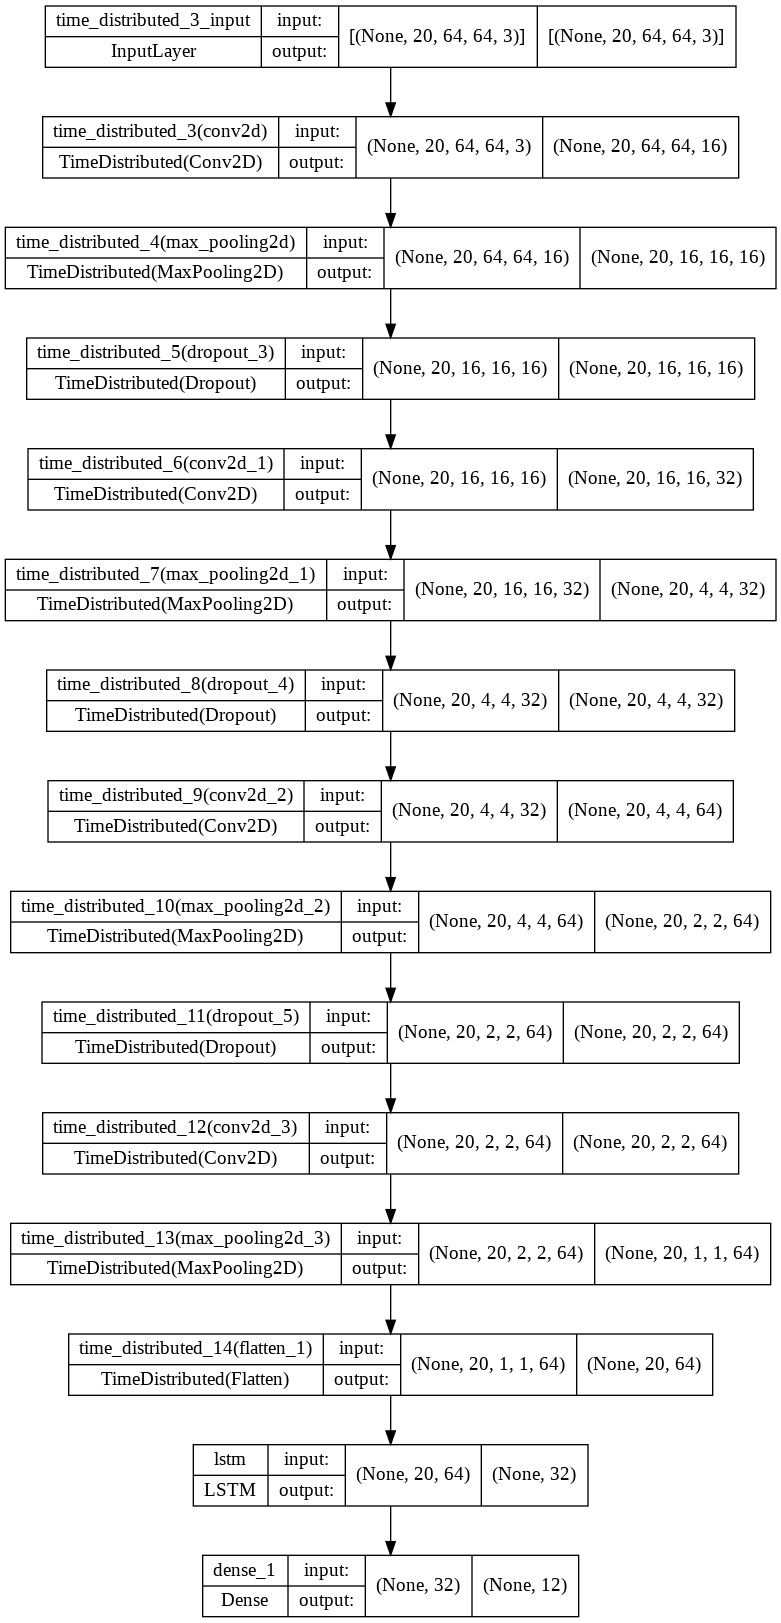

In [26]:
# Plot the structure of the contructed LRCN model.
plot_model(LRCN_model, to_file = 'LRCN_model_structure_plot.png', show_shapes = True, show_layer_names = True)

# Step 5.2: Compile & Train the Model

In [27]:
# Create an Instance of Early Stopping Callback.
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)
 
# Compile the model and specify loss function, optimizer and metrics to the model.
LRCN_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])
 
# Start training the model.
LRCN_model_training_history = LRCN_model.fit(x = features_train, y = labels_train, epochs = 15, batch_size = 4 , shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])


Epoch 1/15
246/246 [==============================] - 6s 12ms/step - loss: 2.4536 - accuracy: 0.1162 - val_loss: 2.4588 - val_accuracy: 0.0691
Epoch 2/15
246/246 [==============================] - 2s 9ms/step - loss: 2.1490 - accuracy: 0.2212 - val_loss: 2.1270 - val_accuracy: 0.3171
Epoch 3/15
246/246 [==============================] - 2s 9ms/step - loss: 1.7778 - accuracy: 0.3945 - val_loss: 1.5858 - val_accuracy: 0.4553
Epoch 4/15
246/246 [==============================] - 2s 9ms/step - loss: 1.4538 - accuracy: 0.5036 - val_loss: 1.5150 - val_accuracy: 0.4756
Epoch 5/15
246/246 [==============================] - 2s 9ms/step - loss: 1.3042 - accuracy: 0.5770 - val_loss: 1.5277 - val_accuracy: 0.4837
Epoch 6/15
246/246 [==============================] - 2s 9ms/step - loss: 1.1630 - accuracy: 0.6106 - val_loss: 1.1315 - val_accuracy: 0.6220
Epoch 7/15
246/246 [==============================] - 2s 9ms/step - loss: 0.9834 - accuracy: 0.6962 - val_loss: 1.1299 - val_accuracy: 0.6504
Epoch

# Evaluating the trained Model

In [28]:
# Evaluate the trained model.
model_evaluation_history = LRCN_model.evaluate(features_test, labels_test)

13/13 [==============================] - 1s 31ms/step - loss: 0.6557 - accuracy: 0.8240


# Save the Model

In [29]:
# Get the loss and accuracy from model_evaluation_history.
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history
 
# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)
    
# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'LRCN_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'
 
# Save the Model.
LRCN_model.save(model_file_name)

# Step 5.3: Plot Model’s Loss & Accuracy Curves

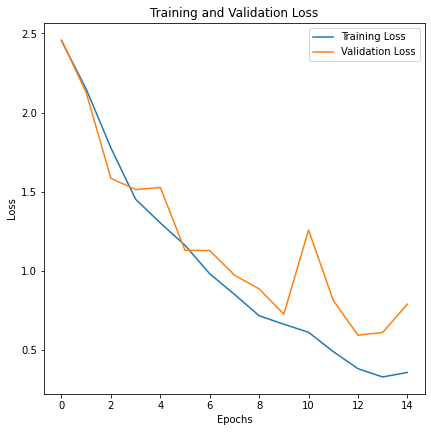

In [31]:
# Visualize the training and validation loss metrices.


loss = LRCN_model_training_history.history['loss']
val_loss = LRCN_model_training_history.history['val_loss']

epoch_value=15
epochs_range = range(epoch_value)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()


Text(0, 0.5, 'Accuracy')

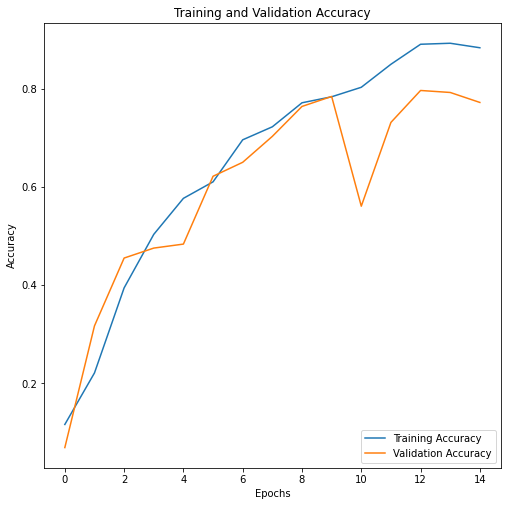

In [32]:
# Visualize the training and validation accuracy metrices.

accuracy = LRCN_model_training_history.history['accuracy']
val_accuracy = LRCN_model_training_history.history['val_accuracy']

epochs_range = range(epoch_value)

plt.figure(figsize=(18, 18))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

In [33]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = LRCN_model.predict(features_test)
Y_pred_classes = np.argmax(y_pred,axis = 1)
Y_true = np.argmax(labels_test,axis = 1)
cm = confusion_matrix(Y_true, Y_pred_classes)

Text(0.5, 1.0, 'Confusion Matrix')

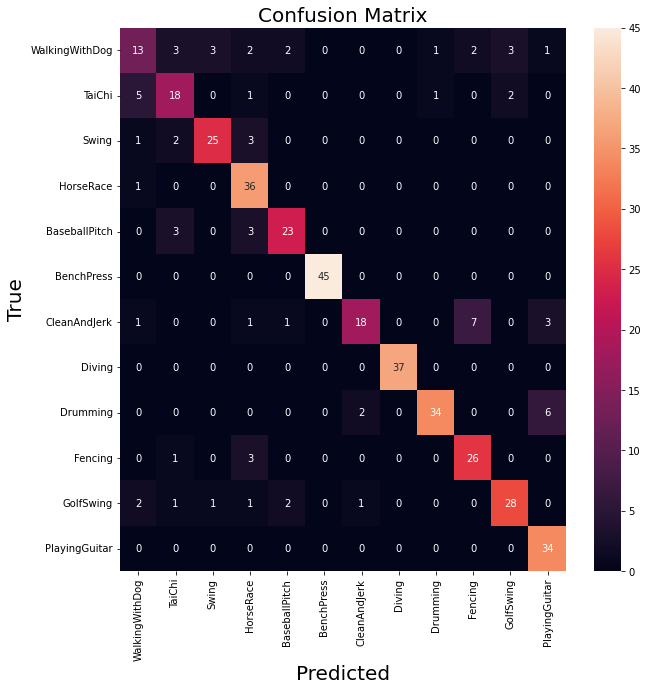

In [34]:
from sklearn.metrics import ConfusionMatrixDisplay
import seaborn as sns


fig = plt.figure(figsize=(10, 10))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g'); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted', fontsize=20)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(CLASSES_LIST, fontsize = 10)
ax.xaxis.tick_bottom()

ax.set_ylabel('True', fontsize=20)
ax.yaxis.set_ticklabels(CLASSES_LIST, fontsize = 10)
plt.yticks(rotation=0)

plt.title('Confusion Matrix', fontsize=20)